<a href="https://colab.research.google.com/github/benjaminsw/generic-VI/blob/main/Variational_Inference_TDS_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optax

In [2]:
from functools import partial

import jax
from jax import jit, grad, random, vmap
import jax.numpy as jnp
import jax.scipy as jsp
from matplotlib import pyplot as plt
import optax
from sklearn import datasets

In [3]:
digits = datasets.load_digits()
is_zero = digits.target == 0
X_train = digits.images[is_zero]

Show one example digit.

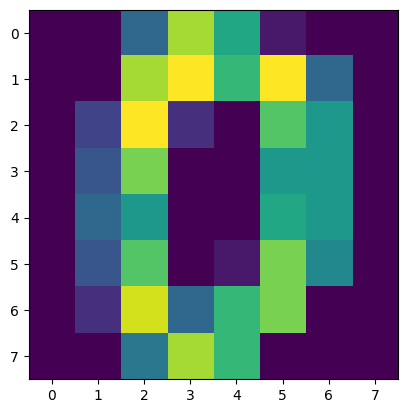

In [4]:
plt.imshow(X_train[0])
plt.savefig('zero_digit.svg')
plt.savefig('zero_digit.png')

In [5]:
n_pixels = 64
X_train = X_train.reshape((-1, n_pixels))

Assume that for each digit, the pixels  $\pmb{x}^{(i)}$ in image $i=1,\dots,m$ are generated from a single set of $\pmb{\Theta}$. Specifically, assume that the intensity of the pixels (a count) is Poisson distributed according to a gamma distributed mean:
$$
p(\pmb{x}^{(i)}, \pmb{\Theta}) = \mathrm{Pois}(\pmb{x}^{(i)}|\pmb{\Theta}) \mathrm{Gam}(\pmb{\Theta}|a, b).
$$
A domain expert may have some idea what the digit zero looks like. He can inform you what is a reasonable starting point for the pixel intensities $\pmb{\Theta}$. We can directly infuse this prior knowledge in the model by choosing the parameters $a$ and $b$.

(-0.5, 7.5, 7.5, -0.5)

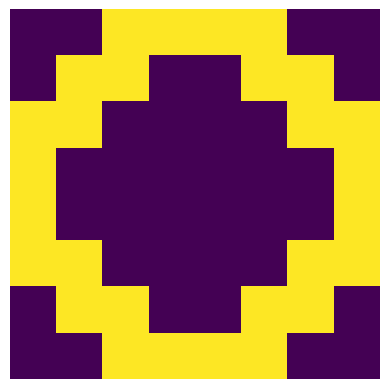

In [6]:
x_domain_knowledge = jnp.array(
  [[ 1,  1, 16, 16, 16, 16,  1,  1],
  [ 1, 16, 16,  1,  1, 16, 16,  1],
  [16, 16,  1,  1,  1,  1, 16, 16],
  [16,  1,  1,  1,  1,  1,  1, 16],
  [16,  1,  1,  1,  1,  1,  1, 16],
  [16, 16,  1,  1,  1,  1, 16, 16],
  [ 1, 16, 16,  1,  1, 16, 16,  1],
  [ 1,  1, 16, 16, 16, 16,  1,  1]],
).flatten()
plt.imshow(x_domain_knowledge.reshape(8, 8))
plt.axis('off')

In [7]:
# Hyperparameters of the model.
a = 2. * x_domain_knowledge
b = 2.

def log_joint(θ):
  log_likelihood = jnp.sum(jsp.stats.gamma.logpdf(θ, a, scale=1./b))
  log_likelihood += jnp.sum(jsp.stats.poisson.logpmf(X_train, θ))
  return log_likelihood

We estimate the posterior using variational inference. The trick is to minimise the evidence lower bound (ELBO)
$$
\mathcal{L}(\pmb{\Theta}) = \mathrm{E}_{q(\pmb{\Theta}|\pmb{\Phi})} \left[ \ln p(\pmb{X}, \pmb{\Theta}) - \ln q(\pmb{\Theta}|\pmb{\Phi}) \right],
$$
with respect to (the variational) distribution $q(\pmb{\Theta}|\pmb{\Phi})$ (we denoted $\pmb{X} = [\pmb{x}^{(1)},\dots,\pmb{x}^{(m)}]^T$ as a shorthand). In practice, we choose a $q$ that is easy to sample, adjust its parameters $\pmb{\Phi}$, and estimate the average using samples of $q$.

In our case, we make the simplification that q factorises (i.e., mean field approximation) into gamma's with shape $\alpha_j$ and rate $\beta_j$. One gamma distribution per pixel $j$:
$$
q(\pmb{\Theta}|\pmb{\Phi}) = \prod_{j=1}^n \mathrm{Gamma}(\theta_j | \alpha_j, \beta_j),
$$

where denote the entire set of parameters as $\pmb{\Phi} = \{ \alpha_j, \beta_j \}_{j=1}^{n}$.

In [8]:
from pandas.io.formats.printing import Dict
@partial(vmap, in_axes=(0, None, None))
def evidence_lower_bound(θ_i, alpha, inv_beta):
  elbo = log_joint(θ_i) - jnp.sum(jsp.stats.gamma.logpdf(θ_i, alpha, scale=inv_beta))
  return elbo

def loss(Φ: dict, key):
  """Stochastic estimate of evidence lower bound."""
  alpha = jnp.exp(Φ['log_alpha'])
  inv_beta = jnp.exp(-Φ['log_beta'])

  # Sample a batch from variational distribution q.
  batch_size = 128
  θ_samples = random.gamma(key, alpha , shape=[batch_size, n_pixels]) * inv_beta

  # Compute Monte Carlo estimate of evidence lower bound.
  elbo_loss = jnp.mean(evidence_lower_bound(θ_samples, alpha, inv_beta))

  # Turn elbo into a loss.
  return -elbo_loss

In [9]:
# Initialise parameters using prior.
Φ = {
    'log_alpha': jnp.log(a),
    'log_beta': jnp.full(fill_value=jnp.log(b), shape=[n_pixels]),
}

loss_val_grad = jit(jax.value_and_grad(loss))
optimiser = optax.adam(learning_rate=0.2)
opt_state = optimiser.init(Φ)

In [10]:
n_iter = 5_000
key, rng_key = random.split(random.PRNGKey(42))
keys = random.split(rng_key, num=n_iter)

for i, key in enumerate(keys):
  elbo, grads = loss_val_grad(Φ, key)
  updates, opt_state = optimiser.update(grads, opt_state)
  Φ = optax.apply_updates(Φ, updates)
  if i % 100 == 0:
    print(f'{i}: ELBO loss', elbo)

0: ELBO loss 114453.19
100: ELBO loss 22621.654
200: ELBO loss 22043.814
300: ELBO loss 21841.412
400: ELBO loss 21751.21
500: ELBO loss 21691.906
600: ELBO loss 21658.844
700: ELBO loss 21631.492
800: ELBO loss 21622.262
900: ELBO loss 21606.408
1000: ELBO loss 21599.525
1100: ELBO loss 21593.137
1200: ELBO loss 21587.607
1300: ELBO loss 21582.547
1400: ELBO loss 21578.781
1500: ELBO loss 21578.59
1600: ELBO loss 21574.67
1700: ELBO loss 21577.129
1800: ELBO loss 21573.684
1900: ELBO loss 21572.172
2000: ELBO loss 21574.094
2100: ELBO loss 21572.225
2200: ELBO loss 21571.617
2300: ELBO loss 21570.883
2400: ELBO loss 21570.43
2500: ELBO loss 21570.494
2600: ELBO loss 21569.99
2700: ELBO loss 21570.373
2800: ELBO loss 21570.266
2900: ELBO loss 21573.533
3000: ELBO loss 21569.176
3100: ELBO loss 21569.79
3200: ELBO loss 21569.65
3300: ELBO loss 21571.457
3400: ELBO loss 21571.254
3500: ELBO loss 21570.992
3600: ELBO loss 21570.273
3700: ELBO loss 21571.658
3800: ELBO loss 21570.826
3900:

Because the gamma and Poisson distribution are conjugate, we know the posterior of $\pmb{\Theta}$ in closed form:
$$
p(\pmb{\Theta} | \pmb{x}^{(1)},\dots,\pmb{x}^{(m)}) = \mathrm{Gam}\left(\pmb{\Theta}|\pmb{a} + \sum_{i=1}^m \pmb{x}^{(i)}, \pmb{b} + m \right).
$$

In [11]:
alpha = jnp.exp(Φ['log_alpha'])
inv_beta = jnp.exp(-Φ['log_beta'])
θ_interval = jnp.linspace(0, 16, 100)[:, None]

# Variational density.
q_z = jsp.stats.gamma.pdf(θ_interval, alpha, scale=inv_beta)

# Density of exact solution.
alpha_true = a + X_train.sum(axis=0)
beta_true = b + len(X_train)
p_z_true = jsp.stats.gamma.pdf(θ_interval, alpha_true, scale=1/(beta_true))

(<matplotlib.patches.Rectangle at 0x7b38a32e29b0>,
 (<matplotlib.patches.ConnectionPatch at 0x7b38a330d690>,
  <matplotlib.patches.ConnectionPatch at 0x7b38a330dcc0>))

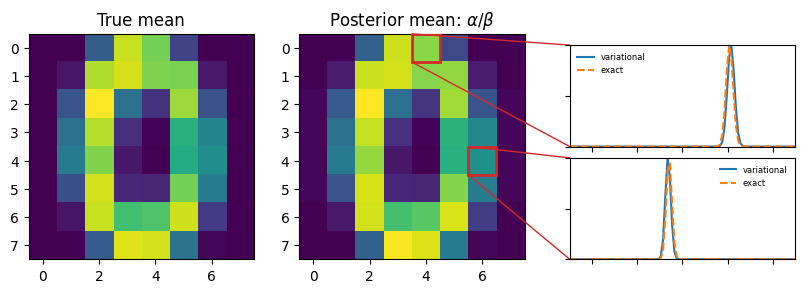

In [12]:
f, axs = plt.subplots(1, 2)
axs[0].set_title('True mean')
axs[0].imshow(X_train.mean(axis=0).reshape(8, 8))
axs[1].set_title(r'Posterior mean: $\alpha / \beta$')
mean = alpha * inv_beta
axs[1].imshow(mean.reshape(8, 8))

def inset_distribution(x, y, alpha, inv_beta, ax):
  """Inset comparing exact with variational solution"""
  ax.set_xlim(x-0.5, x+0.5)
  ax.set_ylim(y-0.5, y+0.5)
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  p_var = q_z.reshape(-1, 8, 8)[:, y, x]
  p_true = p_z_true.reshape(-1, 8, 8)[:, y, x]
  prob_scale = max(*p_var, *p_true)
  # Shift to (x, y) and scale to (1, 1).
  x_transl = θ_interval/16 + x - 0.5
  y_var = p_var / prob_scale + y - 0.5
  y_true = p_true / prob_scale + y - 0.5
  ax.plot(x_transl, y_var, '-', label='variational')
  ax.plot(x_transl, y_true, '--', label='exact')
  ax.legend(frameon=False, prop={'size': 6}, loc='best')


axin1 = axs[1].inset_axes([1.2, 0.5, 1.0, 0.45])
axin2 = axs[1].inset_axes([1.2, 0.0, 1.0, 0.45])

inset_distribution(4, 0, alpha, inv_beta, axin1)
axs[1].indicate_inset_zoom(axin1, edgecolor="tab:red", linewidth=2.0, alpha=1.)

inset_distribution(6, 4, alpha, inv_beta, axin2)
axs[1].indicate_inset_zoom(axin2, edgecolor="tab:red", linewidth=2.0, alpha=1.)

## Bonus: Generative modelling
We can now easily generate new images using the posterior:
- Sample $\pmb{\Theta} \sim q(\pmb{\Theta}|\pmb{\Phi})$
- Sample $\pmb{x} \sim \mathrm{Poisson}(\pmb{x}|\pmb{\Theta})$.

In [13]:
# 1) Generate pixel-level intensities for 10 images.
key_θ, key_x = random.split(key)
m_new_images, n_pixels = 10, 64
θ_samples = random.gamma(key_θ, alpha , shape=[m_new_images, n_pixels]) * inv_beta

# 2) Sample 10 image from intensities.
X_synthetic = random.poisson(key_x, θ_samples)

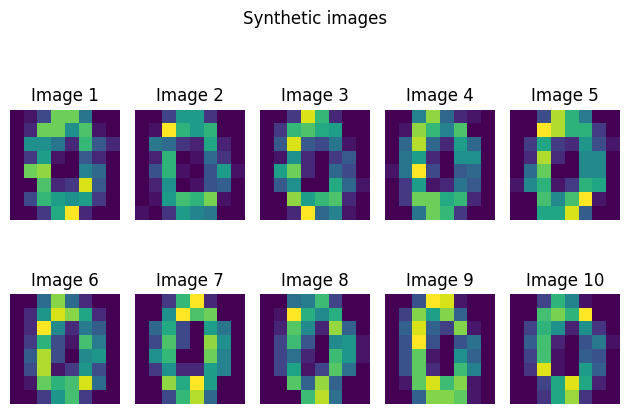

In [14]:
f, axs = plt.subplots(2, 5)
f.suptitle('Synthetic images')
for i, (x_i, ax) in enumerate(zip(X_synthetic, axs.flatten())):
  ax.set_title(f'Image {i+1}')
  ax.imshow(x_i.reshape(8, 8))
  ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
